In [1]:
from sensor_setup import sensor_setup
f_u = sensor_setup.T_cam1_to_img1[0,0]
f_v = sensor_setup.T_cam1_to_img1[1,1]
focal_len = (f_u, f_v)
c_u = sensor_setup.T_cam1_to_img1[0,2]
c_v = sensor_setup.T_cam1_to_img1[1,2]
center_pos = (c_u, c_v)
baseline = - 1/f_u * sensor_setup.T_cam1_to_img1[0,3]

In [2]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as nps

class KittiSlamDataloader:
    # https://stackoverflow.com/questions/42983569/how-to-write-a-generator-class
    def __init__(self, source_directory):
        self.source_directory = source_directory
    
    def __getitem__(self, key):
        path_left = os.path.join(self.source_directory, 'image_0', '%06d.png'%key)
        path_right = os.path.join(self.source_directory, 'image_1', '%06d.png'%key)
        img_left, img_right = cv2.imread(path_left), cv2.imread(path_right)
        return img_left, img_right
    
img_stream = KittiSlamDataloader(source_directory='D:\\DATASETS\\Kitti_SLAM\\dataset\\sequences\\00')


class StereoCamera:
    def __init__(self, baseline, focal_len, center_pos):
        # intrinsics
        self.baseline = baseline # in meter
        self.focal_len = focal_len # in pixels
        self.center_pos = center_pos # in pixels, in pixel coordinates

    def transform_keypoints_in_camera_coordinates(self, keypoints_left, keypoints_right, matches):
        '''
        Inverse camera model: Recover the depth from the stereo vision pixels.    

        see: First Principles of Computer Vision - Simple Stereo | Camera Calibration
        https://www.youtube.com/watch?v=hUVyDabn1Mg&t=330s
        '''        
        kp_l = [keypoints_left[match.queryIdx] for match in matches]
        kp_r = [keypoints_right[match.trainIdx] for match in matches]
        u_l, v_l = cv2.KeyPoint.convert(kp_l).T
        u_r, v_r = cv2.KeyPoint.convert(kp_r).T
        
        b, c_x, c_y, f_x, f_y = self.baseline, *self.center_pos, *self.focal_len # alias

        d = u_l - u_r # disparity
        x = b * (u_l - c_x) / d
        y = b * f_x/f_y * (v_l - c_y) / d
        z = b * f_x / d
        
        xyz = np.stack([x,y,z], axis=1)
        return xyz


In [3]:
import numpy as np

def create_3d_img(img1, img2):
    r = img1.copy()
    r[:,:,1:] = 0
    b = img2.copy()
    b[:,:,:-1] = 0
    return r + b

def filter_horizontal_matches(kp1, kp2, matches):
    good_matches = []
    for match in matches:
        pt1 = tuple(int(x) for x in kp1[match.queryIdx].pt)
        pt2 = tuple(int(x) for x in kp2[match.trainIdx].pt)
        if np.abs(pt1[1] - pt2[1]) <= 5:
            good_matches.append(match)
    return good_matches

def filter_matches_by_distance_ratio(knn_matches):
    '''ratio test as per Lowe's paper: If the ratio is close to 1, both matches are
    equally good and choosing one would give you an outlier in around 50%. Therefore
    it is usually better to discard both matches.
    https://docs.opencv.org/3.4/dc/dc3/tutorial_py_matcher.html
    https://stackoverflow.com/questions/51197091/how-does-the-lowes-ratio-test-work
    '''
    good_matches = []
    for i, knn_match in enumerate(knn_matches):
        m1, m2 = knn_match[0], knn_match[1]
        if m1.distance < 0.7*m2.distance: 
            good_matches.append(m1)
    return good_matches

def filter_matches_by_distance(matches):
    fig, ax = plt.subplots()
    ax.hist([m.distance for m in matches], bins=100)
    plt.show()
    
    n_matches = min(750, len(matches))
    sorted_matches = sorted(matches, key=lambda x: x.distance)
    good_matches = sorted_matches[:n_matches]
    return good_matches

def draw_matches_custom(img1, kp1, img2, kp2, matches):
    fig, ax = plt.subplots(figsize=[10,20])
    blended = cv2.addWeighted(img1, 0.5, img2, 0.5, 0.0)
    # blended = create_3d_img(img1, img2)
    cv2.drawKeypoints(blended, kp1, blended, color=(0,255,0))
    cv2.drawKeypoints(blended, kp2, blended, color=(255,0,0))
    for match in matches:
        pt1 = tuple(int(x) for x in kp1[match.queryIdx].pt)
        pt2 = tuple(int(x) for x in kp2[match.trainIdx].pt)
        blended = cv2.line(blended, pt1, pt2, color=(0,0,255), thickness=1)
    ax.imshow(blended)
    plt.show()

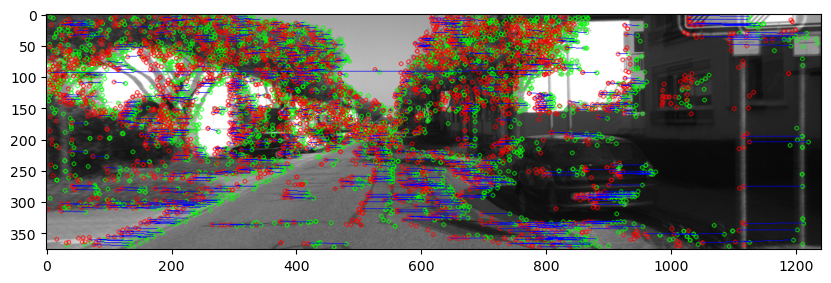

(0.0, 50.0)

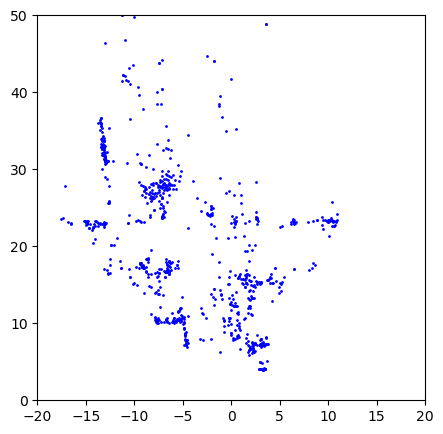

In [4]:
t = 0
detector = cv2.SIFT_create()
descriptor = cv2.SIFT_create()
matcher = cv2.DescriptorMatcher_create(cv2.DescriptorMatcher_FLANNBASED)
tracking_matcher = cv2.DescriptorMatcher_create(cv2.DescriptorMatcher_BRUTEFORCE_SL2)
camera_model = StereoCamera( baseline, focal_len, center_pos)

index_params = dict(algorithm = 1, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary
flann = cv2.FlannBasedMatcher(index_params,search_params)
matcher = flann
tracking_matcher = flann

img_left, img_right = img_stream[t]
kp_left, kp_right = detector.detect(img_left), detector.detect(img_right)
_, des_left = descriptor.compute(img_left, kp_left)
_, des_right = descriptor.compute(img_right, kp_right)

dst = cv2.addWeighted(img_left, 0.5, img_right, 0.5, 0.0)
cv2.drawKeypoints(dst, kp_left, dst, color=(0,255,0))
cv2.drawKeypoints(dst, kp_right, dst, color=(255,0,0))

matches = matcher.knnMatch(des_left, des_right, k=2)
matches = filter_matches_by_distance_ratio(matches)
matches = filter_horizontal_matches(kp_left, kp_right, matches)
# matches = filter_matches_by_distance(matches)
draw_matches_custom(img_left, kp_left, img_right, kp_right, matches)

xyz = camera_model.transform_keypoints_in_camera_coordinates(kp_left, kp_right, matches)
plt.figure(figsize=[5,5])
plt.scatter(xyz[:, 0], xyz[:, -1], color='blue', s=1)
plt.xlim(-20, 20)
plt.ylim(0, 50)

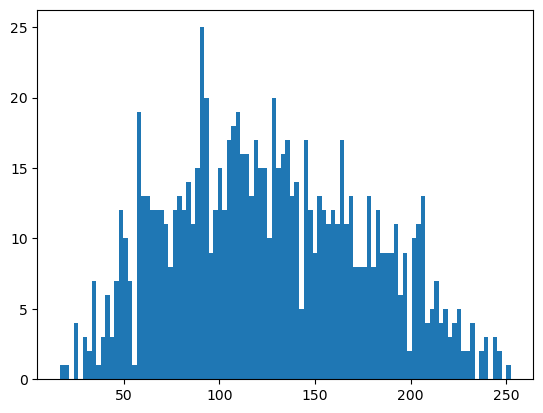

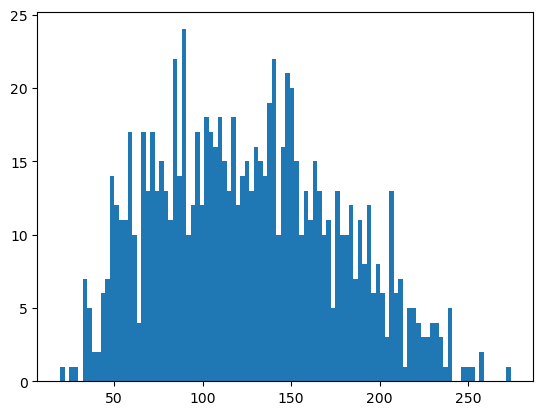

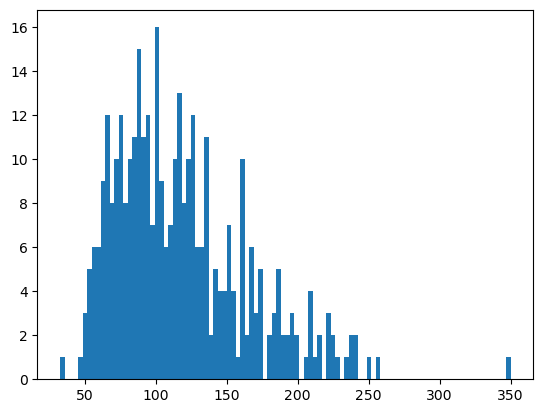

(0.0, 50.0)

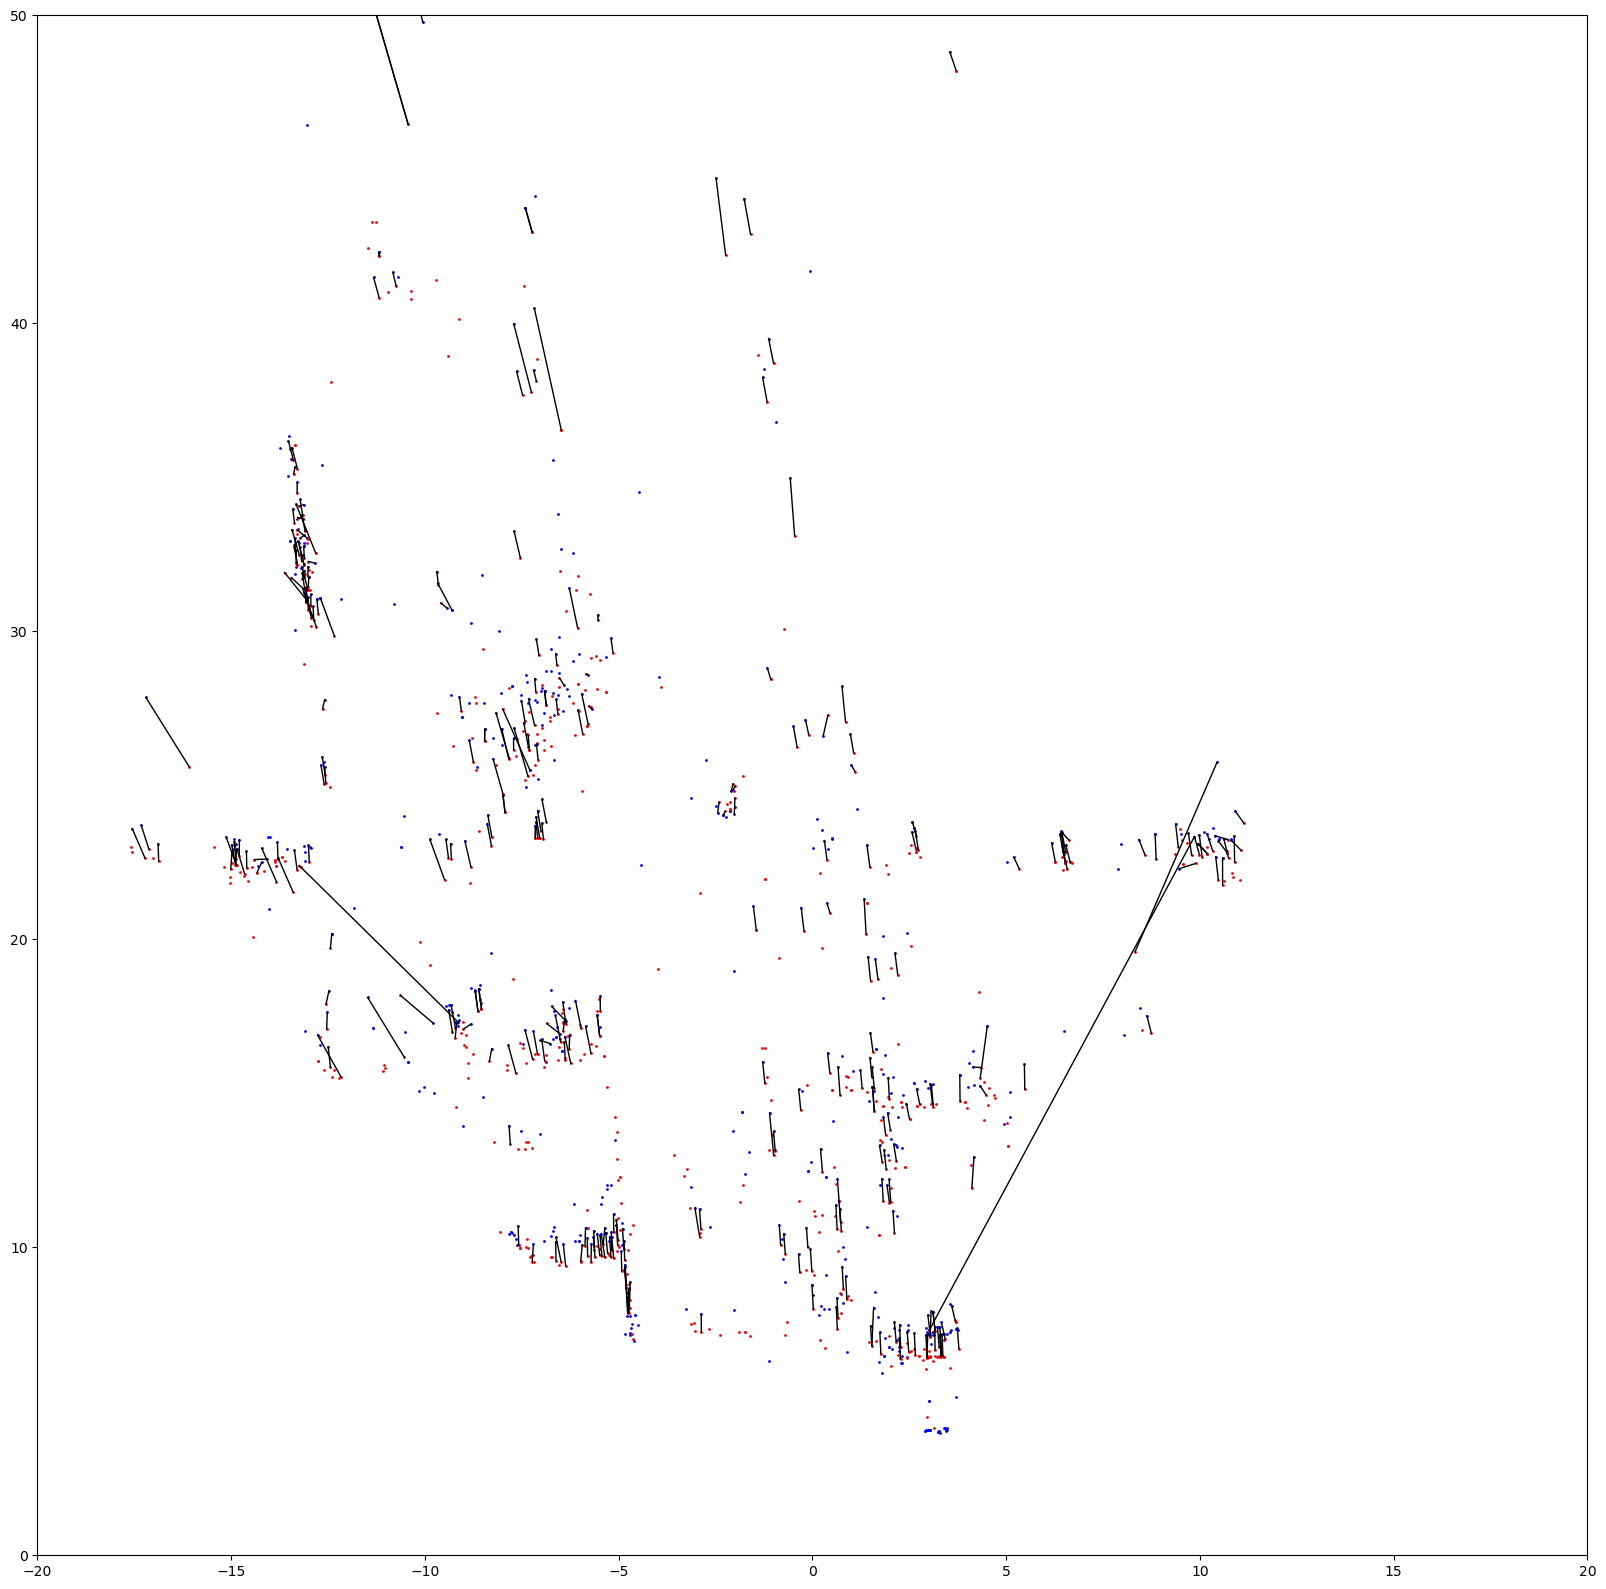

In [6]:
def get_xyz(t):
    img_left, img_right = img_stream[t]
    kp_left, kp_right = detector.detect(img_left), detector.detect(img_right)
    _, des_left = descriptor.compute(img_left, kp_left)
    _, des_right = descriptor.compute(img_right, kp_right)

    matches = matcher.knnMatch(des_left, des_right, k=2)
    matches = filter_matches_by_distance_ratio(matches)
    matches = filter_horizontal_matches(kp_left, kp_right, matches)
    matches = filter_matches_by_distance(matches)
    xyz = camera_model.transform_keypoints_in_camera_coordinates(kp_left, kp_right, matches)
    des = np.hstack([[des_left[match.queryIdx] for match in matches],
                     [des_right[match.trainIdx] for match in matches]])
    return xyz, des

def draw_matches_3d(xyz_0, xyz_1, tracking_matches):
    plt.figure(figsize=[20,20])
    plt.scatter(xyz_0[:, 0], xyz_0[:, -1], color='blue', s=1)
    plt.scatter(xyz_1[:, 0], xyz_1[:, -1], color='red', s=1)
    for match in tracking_matches:
        x = [xyz_0[match.queryIdx, 0], xyz_1[match.trainIdx, 0]]
        y = [xyz_0[match.queryIdx, 2], xyz_1[match.trainIdx, 2]]
        plt.plot(x, y, c='k', lw=1)

xyz_0, des_0 = get_xyz(0)
xyz_1, des_1 = get_xyz(1)

# plt.figure(figsize=[5,5])
# plt.scatter(xyz_0[:, 0], xyz_0[:, -1], color='blue', s=1)
# plt.scatter(xyz_1[:, 0], xyz_1[:, -1], color='red', s=1)

tracking_matches = matcher.knnMatch(des_0, des_1, k=2)
tracking_matches = filter_matches_by_distance_ratio(tracking_matches)
tracking_matches = filter_matches_by_distance(tracking_matches)
draw_matches_3d(xyz_0, xyz_1, tracking_matches)
plt.xlim(-20, 20)
plt.ylim(0, 50)

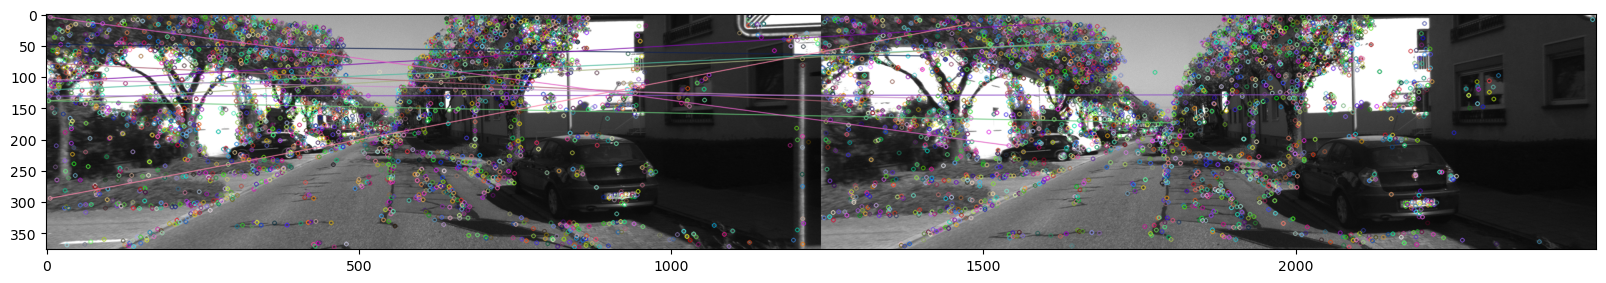

In [79]:
img_left_0, _ = img_stream[0]
img_left_1, _ = img_stream[1]

kp_0, kp_1 = detector.detect(img_left_0), detector.detect(img_left_1)
_, des_0 = descriptor.compute(img_left_0, kp_0)
_, des_1 = descriptor.compute(img_left_1, kp_1)

matches = matcher.match(des_0, des_1)[:10]
res = cv2.drawMatches(img_left_0, kp_0, img_left_1, kp_1, matches, None)
plt.figure(figsize=[20,10])
plt.imshow(res)
plt.show()

In [94]:
# ground_truth
import pandas as pd
from utils.matrix import homogenious_matrix
df_ground_truth = pd.read_csv('data_odometry_poses\\dataset\\poses\\00.txt', sep=' ', header=None)
T_0 = df_ground_truth.iloc[0].to_numpy().reshape(3,4).round(decimals=2)
T_1 = df_ground_truth.iloc[1].to_numpy().reshape(3,4).round(decimals=2)

display(T_0)
display(T_1)

array([[ 1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  0.,  1., -0.]])

array([[ 1.  ,  0.  , -0.  , -0.05],
       [-0.  ,  1.  , -0.  , -0.03],
       [ 0.  ,  0.  ,  1.  ,  0.86]])